# SEC 10-Q Knowledge Graph Construction

This notebook demonstrates constructing a knowledge graph from SEC 10-Q filings using LangChain. The approach uses LLM-based extraction to identify entities and relationships without pre-defining a schema.

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
import neo4j
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dotenv import load_dotenv

load_dotenv()

# Initialize OpenAI client
llm = ChatOpenAI(temperature=0, 
                 model_name="gpt-4o", 
                 api_key=os.environ["OPENAI_API_KEY"])
llm_transformer = LLMGraphTransformer(llm=llm)

In [2]:
import os
from langchain_community.document_loaders.pdf import PyPDFLoader
from langchain_text_splitters import TokenTextSplitter
from langchain.vectorstores.utils import filter_complex_metadata

# Initialize empty list to store all documents
documents = []

# Get the docs directory path
docs_path = "../../data/sec-10-q/docs"

# Loop through all files in the docs directory
for filename in os.listdir(docs_path):
    # Check if the file is an AAPL PDF
        # Construct full file path
    file_path = os.path.join(docs_path, filename)
    
    # Load and process the PDF
    try:
        raw_documents = PyPDFLoader(file_path=file_path).load()
        
        # Split the documents
        text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
        split_documents = text_splitter.split_documents(raw_documents)
        
        # Filter metadata
        processed_documents = filter_complex_metadata(split_documents)
        
        # Append to our collection
        documents.extend(processed_documents)
        
        print(f"Processed: {filename}")
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

# Now all_documents contains the processed documents from all AAPL PDFs
print(f"Total documents processed: {len(documents)}")

Processed: 2023 Q3 MSFT.pdf
Processed: 2023 Q2 AMZN.pdf
Processed: 2023 Q2 AAPL.pdf
Processed: 2023 Q2 MSFT.pdf
Processed: 2023 Q1 AMZN.pdf
Processed: 2023 Q2 NVDA.pdf
Processed: 2022 Q3 NVDA.pdf
Processed: 2023 Q2 INTC.pdf
Processed: 2022 Q3 AAPL.pdf
Processed: 2022 Q3 MSFT.pdf
Processed: 2022 Q3 INTC.pdf
Processed: 2023 Q1 AAPL.pdf
Processed: 2023 Q1 MSFT.pdf
Processed: 2023 Q1 INTC.pdf
Processed: 2023 Q3 INTC.pdf
Processed: 2022 Q3 AMZN.pdf
Processed: 2023 Q3 AMZN.pdf
Processed: 2023 Q3 AAPL.pdf
Processed: 2023 Q3 NVDA.pdf
Processed: 2023 Q1 NVDA.pdf
Total documents processed: 1937


In [22]:
import os
import pickle

# Check if "graph_documents.pkl" exists
if os.path.exists("graph_documents.pkl"):
    # Load graph_documents from the file
    with open("graph_documents.pkl", "rb") as f:
        graph_documents = pickle.load(f)
    print("Loaded graph_documents from graph_documents.pkl")
else:
    # Convert documents to graph documents
    graph_documents = llm_transformer.convert_to_graph_documents(tqdm(documents))
    
    # Save graph_documents to the file
    with open("graph_documents.pkl", "wb") as f:
        pickle.dump(graph_documents, f)
    print("Converted documents to graph_documents and saved to graph_documents.pkl")

Loaded graph_documents from graph_documents.pkl


In [23]:
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph

graph = NetworkxEntityGraph()

# Add nodes to the graph
for doc in graph_documents:
    for node in doc.nodes:
        graph.add_node(node.id)

for doc in graph_documents:
    for edge in doc.relationships:
        graph._graph.add_edge(
            edge.source.id,
            edge.target.id,
            relation=edge.type,
        )

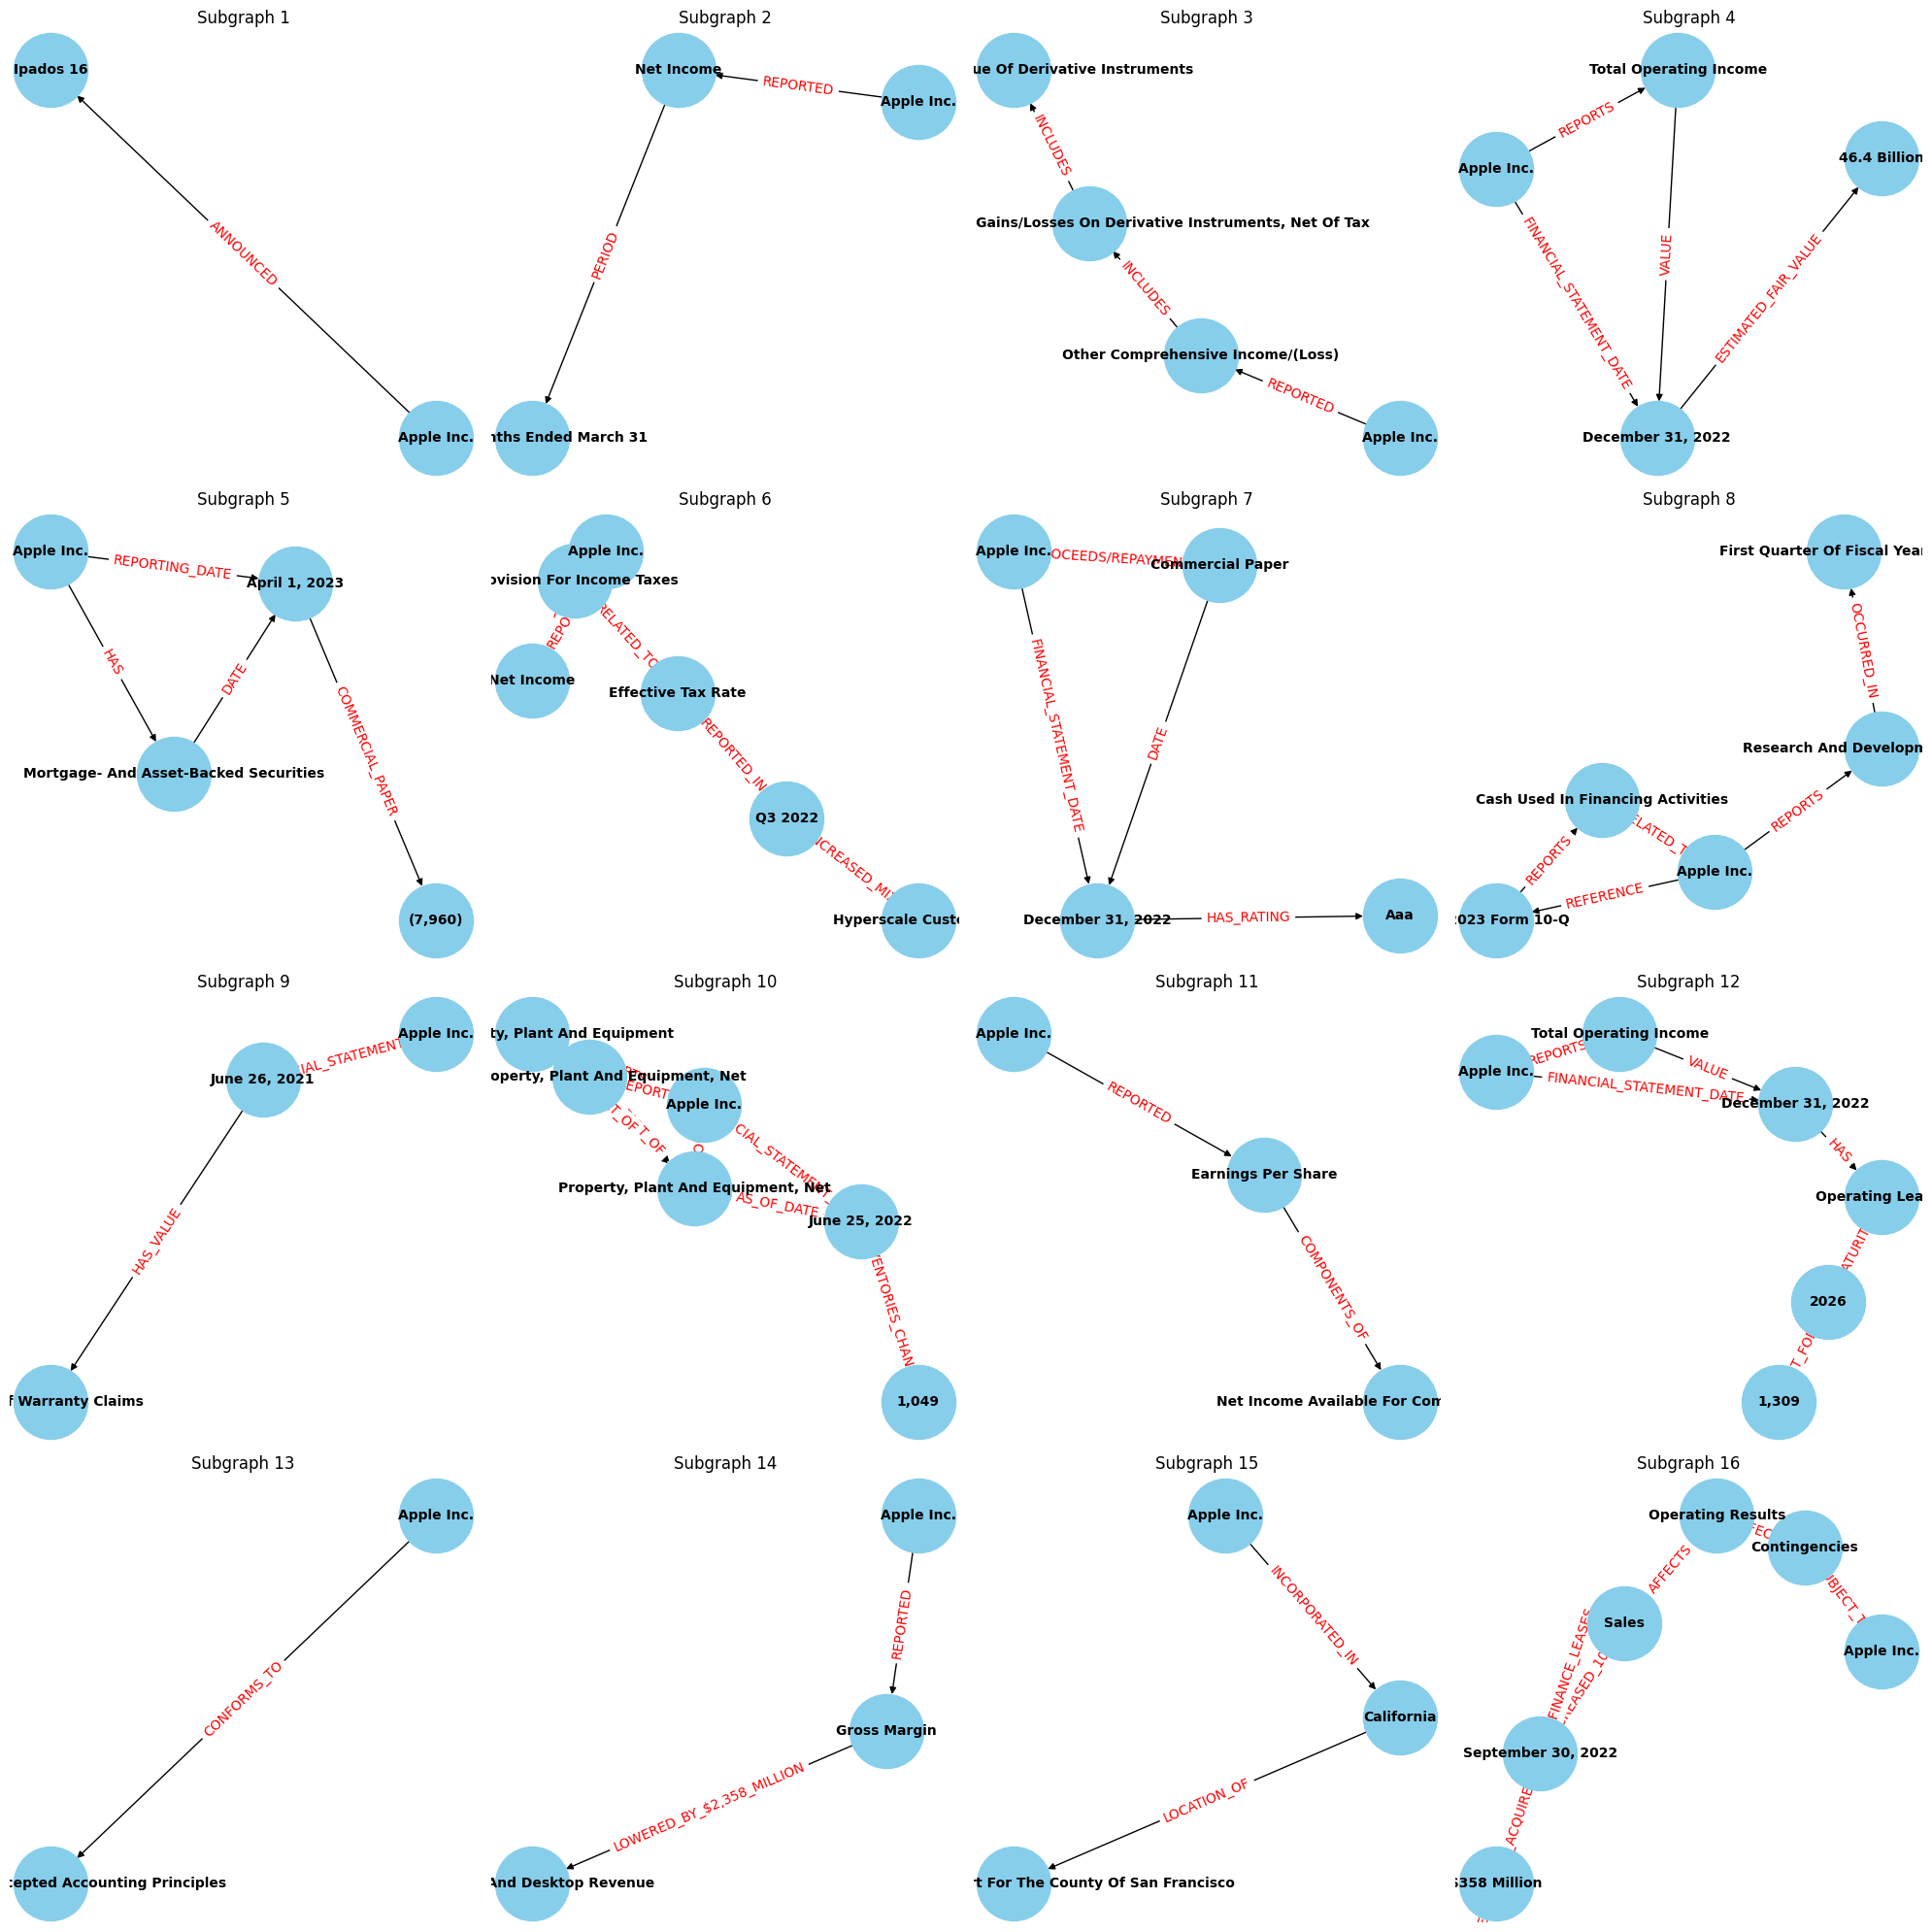

In [75]:
import random

# Define the depth to go down
n_hops = 5

# Select a random node from the graph
random_node = "Apple Inc."

# Function to recursively add a random neighbor up to n_hops
def add_neighbors(node, depth, nodes_to_include):
    if depth > 0:
        neighbors = list(graph._graph.neighbors(node))
        if neighbors:
            random_neighbor = random.choice(neighbors)
            nodes_to_include.add(random_neighbor)
            add_neighbors(random_neighbor, depth - 1, nodes_to_include)

# Create 16 subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(16):
    # Initialize the list of nodes to include in the subgraph
    nodes_to_include = {random_node}
    
    # Add neighbors starting from the random node
    add_neighbors(random_node, n_hops, nodes_to_include)
    
    # Extract the subgraph containing the selected nodes
    subgraph = graph._graph.subgraph(nodes_to_include)
    
    # Draw the subgraph
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", ax=axes[i])
    edge_labels = nx.get_edge_attributes(subgraph, 'relation')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', ax=axes[i])
    axes[i].set_title(f"Subgraph {i+1}")

plt.tight_layout()
plt.show()

The knowledge graph has been constructed and stored in Neo4j. You can now query it using Cypher or use it for downstream tasks like question answering.

In [83]:
from langchain.chains import GraphQAChain

graph_chain = GraphQAChain.from_llm(
    llm=llm, 
    graph=graph, 
    verbose=True,
    n_hops=10
)

In [84]:
graph_chain.invoke(input="Where was Apple Inc. Incorporated?")



> Entering new GraphQAChain chain...
Entities Extracted:
Apple Inc.
Full Context:
Apple Inc. INCORPORATED_IN California
Apple Inc. HAS_IDENTIFIER 94-2404110
Apple Inc. HAS_ADDRESS One Apple Park Way, Cupertino, California 95014
Apple Inc. HAS_CONTACT (408) 996-1010
Apple Inc. FILED Form 10-Q
Apple Inc. REPORTED Products
Apple Inc. REPORTED Services
Apple Inc. REPORTED Total Net Sales
Apple Inc. REPORTED Cost Of Sales
Apple Inc. REPORTED Gross Margin
Apple Inc. REPORTED Operating Expenses
Apple Inc. REPORTED Operating Income
Apple Inc. REPORTED_IN Other Income/(Expense), Net
Apple Inc. REPORTED Income Before Provision For Income Taxes
Apple Inc. REPORTED Provision For Income Taxes
Apple Inc. REPORTED Net Income
Apple Inc. REPORTED Earnings Per Share
Apple Inc. REPORTED Shares Used In Computing Earnings Per Share
Apple Inc. PUBLICATION Q2 2023 Form 10-Q
Apple Inc. REPORTED Other Comprehensive Income/(Loss)
Apple Inc. REPORTED Total Comprehensive Income
Apple Inc. REPORTING_PERIOD Q2 20

{'query': 'Where was Apple Inc. Incorporated?',
 'result': 'Apple Inc. was incorporated in California.'}

In [51]:
graph_chain.invoke(input=" On April 1, 2023, what was the Amount of CASH_BEGINNING_BALANCE?")



> Entering new GraphQAChain chain...
Entities Extracted:
April 1, 2023, CASH_BEGINNING_BALANCE
Full Context:
2023 AS_REPORTED Net_Sales
2023 AS_REPORTED Operating_Expenses
2023 AS_REPORTED Operating_Income
2023 REIMBURSEMENT_YEAR $32 Million Per Quarter
2023 VALUE 2,033
2023 AMOUNT_FOR_YEAR 1,256
2023 REIMBURSED_FOR_COSTS $35 Million Per Quarter
2023 ISSUED_PRINCIPAL_AMOUNT $11.0 Billion
2023 SETTLED_IN_CASH $2.9 Billion
2023 MODIFIED Segment Reporting
2023 IMPACTS Effective_Tax_Rate
2023 SPANS 53_Weeks

> Finished chain.


{'query': ' On April 1, 2023, what was the Amount of CASH_BEGINNING_BALANCE?',
 'result': "I don't know."}

In [48]:
graph_chain.invoke(input="What assets does Apple Inc. have?")



> Entering new GraphQAChain chain...
Entities Extracted:
Apple Inc.
Full Context:
Apple Inc. INCORPORATED_IN California
Apple Inc. HAS_IDENTIFIER 94-2404110
Apple Inc. HAS_ADDRESS One Apple Park Way, Cupertino, California 95014
Apple Inc. HAS_CONTACT (408) 996-1010
Apple Inc. FILED Form 10-Q
Apple Inc. REPORTED Products
Apple Inc. REPORTED Services
Apple Inc. REPORTED Total Net Sales
Apple Inc. REPORTED Cost Of Sales
Apple Inc. REPORTED Gross Margin
Apple Inc. REPORTED Operating Expenses
Apple Inc. REPORTED Operating Income
Apple Inc. REPORTED_IN Other Income/(Expense), Net
Apple Inc. REPORTED Income Before Provision For Income Taxes
Apple Inc. REPORTED Provision For Income Taxes
Apple Inc. REPORTED Net Income
Apple Inc. REPORTED Earnings Per Share
Apple Inc. REPORTED Shares Used In Computing Earnings Per Share
Apple Inc. PUBLICATION Q2 2023 Form 10-Q
Apple Inc. REPORTED Other Comprehensive Income/(Loss)
Apple Inc. REPORTED Total Comprehensive Income
Apple Inc. REPORTING_PERIOD Q2 20

{'query': 'What assets does Apple Inc. have?',
 'result': 'Apple Inc. has the following assets:\n\n- Cash\n- Money Market Funds\n- Mutual Funds\n- U.S. Treasury Securities\n- U.S. Agency Securities\n- Non-U.S. Government Securities\n- Certificates Of Deposit And Time Deposits\n- Corporate Debt Securities\n- Municipal Securities\n- Mortgage- And Asset-Backed Securities'}

In [52]:
graph_chain.invoke(input="Apple inc. What was the amount for Cash Used In Investing Activities in 2023 Q3?")



> Entering new GraphQAChain chain...
Entities Extracted:
Apple
Full Context:
Apple PROVIDES_INFORMATION_ON Www.Apple.Com
Apple PROVIDES_INFORMATION_ON Investor.Apple.Com
Apple ANNOUNCED Macbook Pro 14”
Apple ANNOUNCED Macbook Pro 16”
Apple ANNOUNCED Mac Mini
Apple DISMISSED_CLAIMS_AGAINST Seven Networks, Llc
Apple WITHDREW_FROM_CASE Second Amended Complaint
Apple REGULATED_BY Sec
Apple SELLS Iphone
Apple SELLS Mac
Apple SELLS Ipad
Apple ANNOUNCED Ipad_Pro
Apple ANNOUNCED Apple_Tv_4K

> Finished chain.


{'query': 'Apple inc. What was the amount for Cash Used In Investing Activities in 2023 Q3?',
 'result': "I don't know."}

In [53]:
graph_chain.invoke(input="What was Apple Inc's Products gross margin percentage for the third quarter of 2022? Provide the percentage rounded to one decimal place.") 



> Entering new GraphQAChain chain...
Entities Extracted:
Apple Inc, Products
Full Context:
Products ASSOCIATED_WITH Right_Of_Return
Products MAY_PROVIDE Credits_Or_Incentives
Products ESTIMATE Customer_Usage
Products DEPENDENT_ON Third_Parties
Products MEET Customer Expectations
Products MEET Legal Requirements
Products AFFECT Sales Opportunities
Products FACE Regulatory Actions
Products FACE Legal Actions
Products AFFECTS Sales
Products EXPOSE Claims
Products DAMAGE Reputation
Products LIMIT Growth
Products AFFECT Operating Results
Products HAS_VALUE Gross Margin
Products HAS_VALUE Gross Margin Percentage
Products IMPACTED_BY U.S. Dollar
Products DECREASED_DUE_TO Foreign Currencies
Products SOLD_WITH Right Of Return
Products MAY_PROVIDE Credits
Products MAY_PROVIDE Incentives
Products ESTIMATE Customer Usage
Products SUPPORT Security Advances
Products SUPPORT Standards
Products DEFEND_AGAINST Security Vulnerabilities
Products DEPENDENT_ON Third_Party_Ecosystem
Products BECOME Comple

{'query': "What was Apple Inc's Products gross margin percentage for the third quarter of 2022? Provide the percentage rounded to one decimal place.",
 'result': "I don't know."}

In [ ]:
# Load the CSV file
df = pd.read_csv("../../data/sec-10-q/synthetic_qna_data_7_gpt4o.csv")

# Filter for rows where Source Docs contains only AAPL
apple_df = df[df['Source Docs'].str.contains('AAPL', na=False)]

# Take first 10 samples
apple_df = apple_df.head(10)

# Evaluate the model
correct = 0
for i, row in apple_df.iterrows():
    question = row["New Question"]
    answer = row["New Answer"]
    print(f"\nQuestion: {question}")
    print(f"Expected Answer: {answer}")
    response = graph_chain.invoke(input=question)
    print(f"Model Response: {response}")
    if response == answer:
        correct += 1
        
print(f"\nAccuracy: {correct / 10}")